In [9]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [10]:
BLOCK_SIZE = 7
SEARCH_BLOCK_SIZE = 56

In [11]:
def read_left_right_images(left_image_path="left.png",
                            right_image_path="right.png",
                            target_width=400,
                            target_height=300):
    left_image = cv2.imread(left_image_path, cv2.IMREAD_GRAYSCALE)
    right_image = cv2.imread(right_image_path, cv2.IMREAD_GRAYSCALE)
    left_image = cv2.resize(left_image, (target_width, target_height))
    right_image = cv2.resize(right_image, (target_width, target_height))
    left_image_array = np.asarray(left_image)
    right_image_array = np.asarray(right_image)

    return left_image_array, right_image_array

In [12]:
def calculate_sum_of_abs_diff(pixel_block_1, pixel_block_2):
    """

    Args:
        pixel_block_1 (numpy.ndarray): pixel block from left image
        pixel_block_2 (numpy.ndarray): pixel block from right image

    Returns:
        float: Sum of absolute difference between individual pixels
    """
    if pixel_block_1.shape != pixel_block_2.shape:
        return -1

    return np.sum(np.abs(pixel_block_1 - pixel_block_2))

In [13]:
def find_best_matching_block(y, x, block_left, right_image_array, block_size=5):
    """
    Compare left block of pixels with multiple blocks from the right
    image using SEARCH_BLOCK_SIZE to constrain the search in the right
    image.

    Args:
        y (int): row index of the left block
        x (int): column index of the left block
        block_left (numpy.ndarray): containing pixel values within the 
                    block selected from the left image
        right_image_array (numpy.ndarray]): containing pixel values for the 
                     entrire right image
        block_size (int, optional): Block of pixels width and height. 
                                    Defaults to 5.

    Returns:
        tuple: (y, x) row and column index of the best matching block 
                in the right image
    """
    x_min = max(0, x - SEARCH_BLOCK_SIZE)
    x_max = min(right_image_array.shape[1], x + SEARCH_BLOCK_SIZE)

    first = True
    min_sad = None
    min_index = None

    for x_idx in range(x_min, x_max):
        block_right = right_image_array[y: y+block_size,
                                        x_idx: x_idx+block_size]
        sad = calculate_sum_of_abs_diff(block_left, block_right)
        if first:
            min_sad = sad
            min_index = (y, x_idx)
            first = False
        elif sad < min_sad:
            min_sad = sad
            min_index = (y, x_idx)

    return min_index

In [15]:
def estimate_depth(disparity_map, focal_length, baseline):
    disparity_map[disparity_map == 0] = 1
    
    # Convert disparity to depth
    depth_map = (focal_length * baseline) / disparity_map
    print(depth_map)
   
    return depth_map


In [16]:
def generate_disparity_map(left_image_path, right_image_path):
    left_array, right_array = read_left_right_images(left_image_path, right_image_path)

    left_array = left_array.astype(int)
    right_array = right_array.astype(int)

    if left_array.shape != right_array.shape:
        raise ValueError("Left-Right image shape mismatch!")

    height, width = left_array.shape
    disparity_map = np.zeros((height, width))

    for y in tqdm(range(BLOCK_SIZE, height-BLOCK_SIZE)):
        for x in range(BLOCK_SIZE, width-BLOCK_SIZE):
            block_left = left_array[y:y + BLOCK_SIZE,
                                    x:x + BLOCK_SIZE]
            min_index = find_best_matching_block(y, x, block_left,
                                                right_array,
                                                block_size=BLOCK_SIZE)
            disparity_map[y, x] = abs(min_index[1] - x)

    plt.imshow(disparity_map, cmap='hot', interpolation='nearest')
    plt.savefig('depth_image.png')
    plt.show()

    estimate_depth(disparity_map, 100, 100)


100%|██████████| 286/286 [01:19<00:00,  3.58it/s]


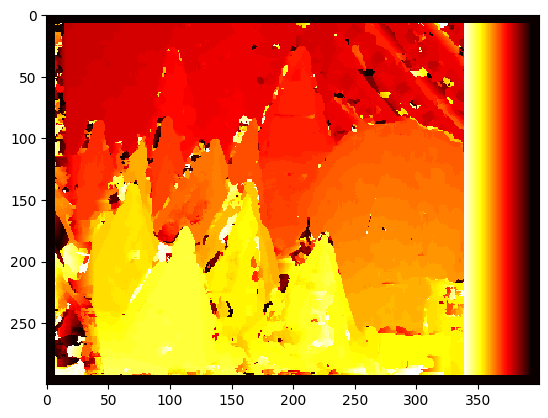

[[10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 ...
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]]


In [17]:
generate_disparity_map('left.png','right.png')